# Self-Driving Car Engineer Nanodegree

## Traffic Sign Recognition Classifier

The steps of this project are the following:
* Load the data set
* Explore, summarize and visualize the data set
* Perform preprocessing and data augmentation
* Design, train and test a model architecture
* Use the model to make predictions on new images
* Analyze the softmax probabilities of the new images

---
## Step 0: Load The Data

### Load Data Set

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [96]:
# Load pickled data
import pickle
import copy

# TODO: Fill this in based on where you saved the training and testing data

data_folder = 'traffic-signs-data/'
training_file = data_folder + 'test.p'
validation_file= data_folder + 'valid.p'
testing_file = data_folder + 'train.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

### Load Class ID Traffic Sign Mapping

In [97]:
import csv

sign_id_dict = {}
with open('signnames.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
        else:
            sign_id_dict[row[0]] = row[1]
            line_count += 1
    print(f'Processed {line_count} lines.')
                  
print(sign_id_dict)

Column names are ClassId, SignName
Processed 44 lines.
{'0': 'Speed limit (20km/h)', '1': 'Speed limit (30km/h)', '2': 'Speed limit (50km/h)', '3': 'Speed limit (60km/h)', '4': 'Speed limit (70km/h)', '5': 'Speed limit (80km/h)', '6': 'End of speed limit (80km/h)', '7': 'Speed limit (100km/h)', '8': 'Speed limit (120km/h)', '9': 'No passing', '10': 'No passing for vehicles over 3.5 metric tons', '11': 'Right-of-way at the next intersection', '12': 'Priority road', '13': 'Yield', '14': 'Stop', '15': 'No vehicles', '16': 'Vehicles over 3.5 metric tons prohibited', '17': 'No entry', '18': 'General caution', '19': 'Dangerous curve to the left', '20': 'Dangerous curve to the right', '21': 'Double curve', '22': 'Bumpy road', '23': 'Slippery road', '24': 'Road narrows on the right', '25': 'Road work', '26': 'Traffic signals', '27': 'Pedestrians', '28': 'Children crossing', '29': 'Bicycles crossing', '30': 'Beware of ice/snow', '31': 'Wild animals crossing', '32': 'End of all speed and passing

---

## Step 1: Dataset Summary & Exploration

### Basic Summary of the Data Set

In [98]:
import numpy as np

### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 12630
Number of testing examples = 34799
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset.

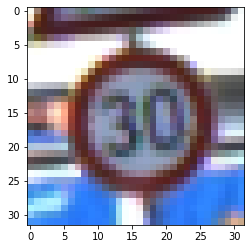

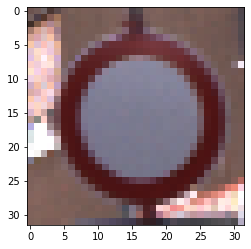

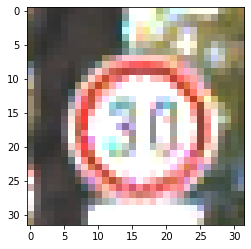

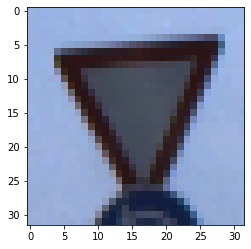

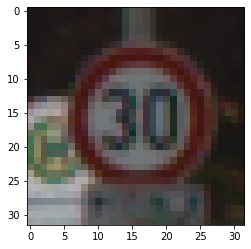

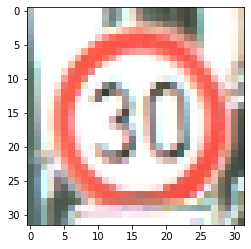

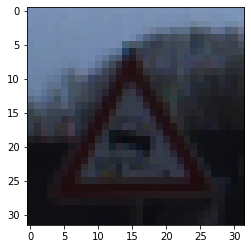

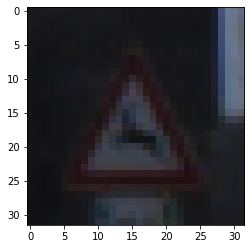

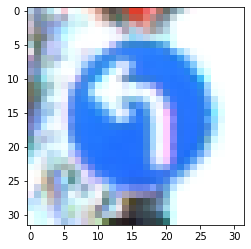

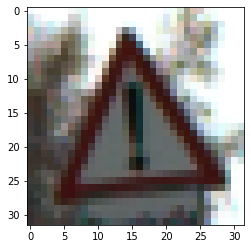

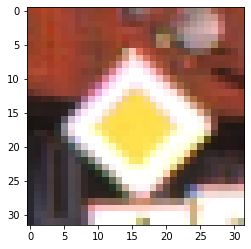

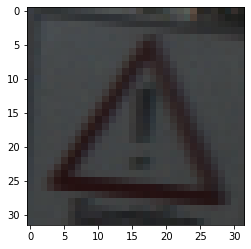

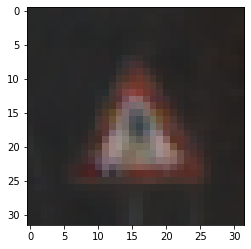

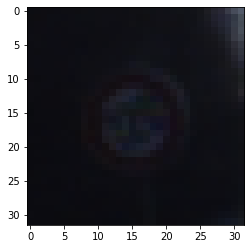

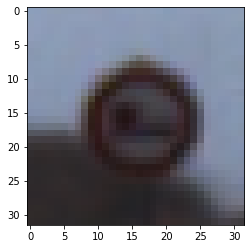

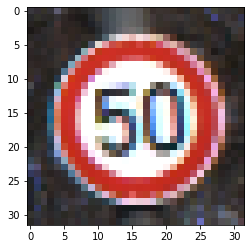

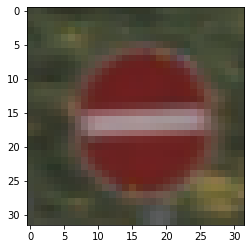

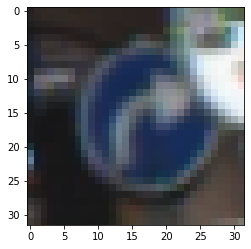

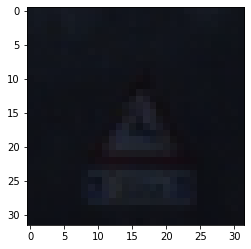

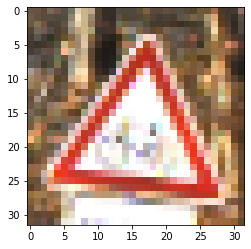

In [99]:
### Data exploration visualization code goes here.
import matplotlib.pyplot as plt
from random import randint
# Visualizations will be shown in the notebook.
%matplotlib inline

for i in range(20):
    index = randint(0, len(X_train))
    img = X_train[index]
    plt.imshow(img)
    plt.show()
    
min_class = np.min(y_train)
max_class = np.max(y_train)

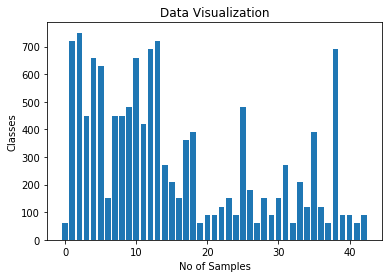

In [100]:
classes_index = []
classes_distributions = []
i = min_class

class_dict = {}
while i <= max_class:
    num = len([1 for sample in y_train if sample == i])
    class_dict[i] = num
    classes_index.append(i)
    classes_distributions.append(num)
    i += 1

plt.bar(classes_index, classes_distributions, align='center')
plt.ylabel('Classes')
plt.xlabel('No of Samples')
plt.title('Data Visualization')
plt.show()

----

## Step 2: Preprocessing


### Pre-process the Data Set (normalization, grayscale, etc.)

In [101]:
import cv2

### Histogram Equalization

Adjust image intensities to enhance contrast.

In [103]:
def equalize_hist(img_rgb):
    img_yuv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

In [ ]:
X_train_temp = []

for img in X_train:
    X_train_temp.append(equalize_hist(img))

X_train = np.array(X_train_temp)

X_valid_temp = []

for img in X_valid:
    X_valid_temp.append(equalize_hist(img))

X_valid = np.array(X_valid_temp)

new_imgs = []
new_img_class = []

### Data Augmentation

Increase the diversity of data available for training models, without actually collecting new data.

In [102]:
def random_brightness(img_rgb):
    img_hsv = cv2.cvtColor(img_rgb,cv2.COLOR_RGB2HSV)
    random_brightness_value = .25+np.random.uniform()
    img_hsv[:,:,2] = img_hsv[:,:,2]*random_brightness_value
    return cv2.cvtColor(img_hsv,cv2.COLOR_HSV2RGB)

In [104]:
def random_translate(img):
    num_rows, num_cols = img.shape[:2]
    
    pixel_limit = 2
    dx,dy = np.random.randint(-pixel_limit,pixel_limit,2)
    
    translation_matrix = np.float32([ [1,0,dx], [0,1,dy] ])
    return cv2.warpAffine(img, translation_matrix, (num_cols, num_rows))

In [105]:
def random_scale(img):   
    num_rows, num_cols = img.shape[:2]

    # transform limits
    pixel_limit = np.random.randint(-2,2)

    # ending locations
    pts1 = np.float32([[pixel_limit,pixel_limit],[num_rows-pixel_limit,pixel_limit], \
                       [pixel_limit,num_cols-pixel_limit],[num_rows-pixel_limit,num_cols-pixel_limit]])

    # starting locations (4 corners)
    pts2 = np.float32([[0,0],[num_rows,0],[0,num_cols],[num_rows,num_cols]])

    M = cv2.getPerspectiveTransform(pts1,pts2)
    
    return cv2.warpPerspective(img,M,(num_rows,num_cols))

In [106]:
def random_rotate(img):
    rows,cols = img.shape[:2]
    angle = np.random.randint(-20, 20) # random angle
    M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),angle,1)
    return cv2.warpAffine(img,M,(cols,rows))

In [107]:
def random_warp(img):
    
    num_rows, num_cols = img.shape[:2]

    # random scaling coefficients
    rndx = np.random.rand(3) - 0.5
    rndx *= num_cols * 0.06
    rndy = np.random.rand(3) - 0.5
    rndy *= num_rows * 0.06

    # 3 starting points for transform, 1/4 way from edges
    x1 = num_cols/4
    x2 = 3*num_cols/4
    y1 = num_rows/4
    y2 = 3*num_rows/4

    pts1 = np.float32([[y1,x1],
                       [y2,x1],
                       [y1,x2]])
    pts2 = np.float32([[y1+rndy[0],x1+rndx[0]],
                       [y2+rndy[1],x1+rndx[1]],
                       [y1+rndy[2],x2+rndx[2]]])

    M = cv2.getAffineTransform(pts1,pts2)

    return cv2.warpAffine(img,M,(num_cols,num_rows))


Demonstrate different augmentation functions on one image of the training set.

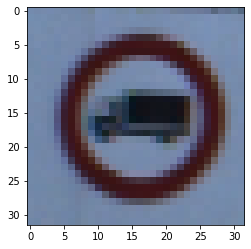

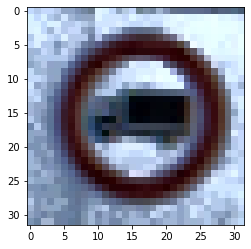

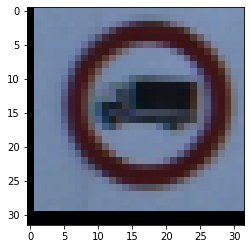

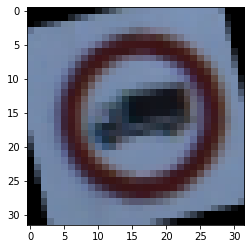

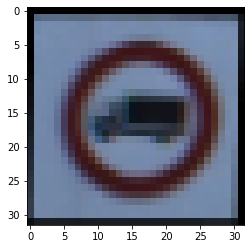

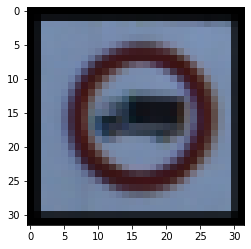

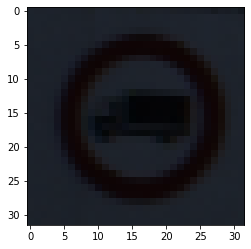

In [109]:
plt.imshow(X_train[0])
plt.show()

plt.imshow(random_translate(X_train[0]))
plt.show()

plt.imshow(random_rotate(X_train[0]))
plt.show()

plt.imshow(random_warp(X_train[0]))
plt.show()

plt.imshow(random_scale(X_train[0]))
plt.show()

plt.imshow(random_brightness(X_train[0]))
plt.show()

Perform data augmentation on images until every class has 3500 data samples.

In [110]:
added_imgs = True

while(1):
    added_imgs = False
    for img, y_class in zip(X_train, y_train):
        
        if class_dict[y_class] >= 3500:
            continue
            
        size_before = len(new_img_class)
            
        new_imgs.append(random_translate(img))
        new_img_class.append(y_class)
        
        new_imgs.append(random_rotate(img))
        new_img_class.append(y_class)
        
        new_imgs.append(random_warp(img))
        new_img_class.append(y_class)
        
        new_imgs.append(random_scale(img))
        new_img_class.append(y_class)
        
        new_imgs.append(random_brightness(img))
        new_img_class.append(y_class)
        class_dict[y_class] += len(new_img_class) - size_before
        added_imgs = True
    if not added_imgs:
        break
    
X_train = np.concatenate((X_train, new_imgs), axis=0).squeeze()
y_train = np.concatenate((y_train, new_img_class), axis=0).squeeze()

Plot class distribution. Now every class should have the same number of data samples.

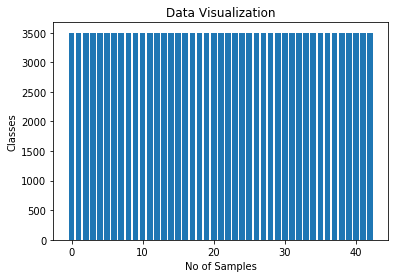

In [111]:
classes_index = []
classes_distributions = []
i = min_class
while i <= max_class:
    num = len([1 for sample in y_train if sample == i])
    classes_index.append(i)
    classes_distributions.append(num)
    i += 1

plt.bar(classes_index, classes_distributions, align='center')
plt.ylabel('Classes')
plt.xlabel('No of Samples')
plt.title('Data Visualization')
plt.show()

### Image Normalization and Greyscale Transformation

In [108]:
def normalize_data(dataset):
    dataset = np.sum(dataset/3, axis=3, keepdims=True)
    return (dataset - 128)/128

In [ ]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

X_train_normalized = normalize_data(X_train)
X_valid_normalized = normalize_data(X_valid)

---

## Step 4: Model Architecture

In [113]:
from tensorflow.keras import datasets, layers, models, regularizers

def cnn_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (7,7), strides=(1, 1), padding='same', \
                        activation='relu', input_shape=(32, 32, 1)))
    model.add(layers.BatchNormalization(axis=-1))      
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (4, 4), activation='relu'))
    model.add(layers.BatchNormalization(axis=-1))      
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l=0.05)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(43, activation='softmax'))
    return model

In [114]:
model = cnn_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        1600      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        32832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0

---

## Step 5: Train, Validate and Test the Model

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

batch_size = 128
epochs = 50

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

lr = 0.01
def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

history = model.fit(X_train_normalized, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_data=(X_valid_normalized, y_valid),
                    callbacks=[LearningRateScheduler(lr_schedule), ModelCheckpoint('model.h5', save_best_only=True)])

Train on 150500 samples, validate on 4410 samples
Epoch 1/50
150500/150500 [==============================] - 478s 3ms/sample - loss: 2.6031 - accuracy: 0.8186 - val_loss: 2.2649 - val_accuracy: 0.9315
Epoch 2/50
150500/150500 [==============================] - 500s 3ms/sample - loss: 2.4515 - accuracy: 0.8284 - val_loss: 2.1034 - val_accuracy: 0.9238
Epoch 3/50
150500/150500 [==============================] - 498s 3ms/sample - loss: 2.3408 - accuracy: 0.8347 - val_loss: 1.8754 - val_accuracy: 0.9488
Epoch 4/50
150500/150500 [==============================] - 495s 3ms/sample - loss: 2.2698 - accuracy: 0.8380 - val_loss: 1.7704 - val_accuracy: 0.9553
Epoch 5/50
150500/150500 [==============================] - 485s 3ms/sample - loss: 2.2287 - accuracy: 0.8411 - val_loss: 1.8963 - val_accuracy: 0.9263
Epoch 6/50
150500/150500 [==============================] - 495s 3ms/sample - loss: 2.1901 - accuracy: 0.8441 - val_loss: 1.9445 - val_accuracy: 0.9542
Epoch 7/50
150500/150500 [============

### Plot Training Performance

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

### Load Best Model

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model(
    'model.h5',
    custom_objects=None,
    compile=True
)

### Evaluate on Validation Set

In [ ]:
test_loss, test_acc = model.evaluate(X_valid_normalized,  y_valid, verbose=2)
print("test: ", test_acc)

### Evaluate on Test Set

In [ ]:
from sklearn.utils import shuffle
X_test, y_test = shuffle(X_test, y_test)

X_test_temp = []

for img in X_test:
    X_test_temp.append(equalize_hist(img))

X_test_normalized = normalize_data(np.array(X_test_temp))

In [ ]:
test_loss, test_acc = model.evaluate(X_test_normalized,  y_test, verbose=2)
print("test: ", test_acc)

In [ ]:
X_test_slice = np.array(X_test_normalized[0:5])

class_prob=model.predict(X_test_slice,batch_size=1)
classifications=model.predict_classes(X_test_slice,batch_size=1)

print(np.amax(class_prob[0]))
print(classifications[0])
plt.imshow(X_test[0], cmap="gray")
plt.show()

print(np.amax(class_prob[1]))
print(classifications[1])
plt.imshow(X_test[1], cmap="gray")
plt.show()

print(np.amax(class_prob[2]))
print(classifications[2])
plt.imshow(X_test[2], cmap="gray")
plt.show()

print(np.amax(class_prob[3]))
print(classifications[3])
plt.imshow(X_test[3], cmap="gray")
plt.show()

print(np.amax(class_prob[4]))
print(classifications[4])
plt.imshow(X_test[4], cmap="gray")
plt.show()

---

## Step 6: Test Model on New Images

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name. The python dictionary `sign_id_dict` contains the content of this csv file.

### Initialize Parameters for Performance Evaluation

In [ ]:
num_correct_classified = 0
num_new_images = 0

### Helper Functions and Constants

In [ ]:
dim = (32, 32)

def process_img(img, correct_class):
    resized = cv2.resize(test_1_img, dim, interpolation = cv2.INTER_AREA)
    plt.imshow(resized)
    plt.show()

    resized = [resized]
    resized = normalize_data(np.array(resized))
    class_prob=model.predict(resized,batch_size=1)
    top_three_pred = np.argsort(class_prob[0])[-5:][::-1]
    print_top_five(top_three_pred, class_prob)

    classifications=model.predict_classes(resized,batch_size=1)

    num_new_images += 1
    if classifications[0] == correct_class:
        num_correct_classified += 1
    
    print('Predicted traffic sign: ', sign_id_dict[str(classifications[0])])

    plt.imshow(class_dict[str(classifications[0])])
    plt.show()
    
def print_top_five(top_three_pred, class_prob):
    print("--- Top 5 class probabilities --- ")
    print("Class ", top_three_pred[0], ": ", class_prob[0][top_three_pred[0]])
    print("Class ", top_three_pred[1], ": ", class_prob[0][top_three_pred[1]])
    print("Class ", top_three_pred[2], ": ", class_prob[0][top_three_pred[2]])
    print("Class ", top_three_pred[3], ": ", class_prob[0][top_three_pred[3]])
    print("Class ", top_three_pred[4], ": ", class_prob[0][top_three_pred[4]])
    print()

### Perform Predictions on New Images

In [ ]:
test_img = plt.imread('./new-test-images/test1.jpg')
plt.imshow(test_img)
plt.show()

process_img(test_img, 33)

In [ ]:
test_img = plt.imread('./new-test-images/test2.jpg')

plt.imshow(test_img)
plt.show()

process_img(test_img, 35)

In [ ]:
test_img = plt.imread('./new-test-images/test3.jpg')
plt.imshow(test_img)
plt.show()

process_img(test_img, 37)

In [ ]:
test_img = plt.imread('./new-test-images/test4.jpg')
plt.imshow(test_img)
plt.show()

process_img(test_img, 28)

In [ ]:
test_img = plt.imread('./new-test-images/test5.jpg')
plt.imshow(test_img)
plt.show()

process_img(test_img, 17)

In [ ]:
test_img = plt.imread('./new-test-images/test6.jpg')
plt.imshow(test_img)
plt.show()

process_img(test_img, 8)

### Analyze Performance

In [ ]:
print("Percentage correctly classified on new images: ", (num_correct_classified/num_new_images)*100, "%")